In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Vars

Тут необходимые входные переменные

In [52]:
# Список имён файлов
file_names = [
    '190',
    '192',
    '193',
    '194',
    '195',
    '196',
    '197',
    '198',
    '199',
    '210',
    '211',
    '212',
    '213',
    '214',
    '215',
    '216',
    '217',
    '218',
    '220',
    '221',
    '224',
    '230',
    '231',
    '232',
    '233',
    '234',
    '235',
    '236',
    '237',
    '239',
    '451',
    '469',
    '511',
    '512',
]

# Пути до файлов .las
path_las = './data/las/'
path_las_facies = './data/las_facies/'

# Functions read files

Тут все необходимые функции

In [53]:
# Читаем файл WELL_TOPS.TXT

def get_well_tops():
    well_tops = open(f"./data/well tops.txt", "r")
    well_tops_dict = {}
    
    first_line = True

    for line in well_tops:
        if first_line:
            first_line = False
            continue

        if line.split()[0] not in well_tops_dict:
            well_tops_dict[line.split()[0]] = {}

        if line.split()[1] == 'Ach8-1_top':
            well_tops_dict[line.split()[0]]['top'] = pd.to_numeric(line.split()[-1])
        elif line.split()[1] == 'Ach8-1_bot':
            well_tops_dict[line.split()[0]]['bot'] = pd.to_numeric(line.split()[-1])
        elif line.split()[1] == 'baz':
            well_tops_dict[line.split()[0]]['baz'] = pd.to_numeric(line.split()[-1])

    return well_tops_dict

In [54]:
# Читаем .las файлы и переводим их в DataFrame
# Вариант с фильтрацией по Wall_tops

# def las_to_df(file_name, path):
    # ascii = []
    # mnem = []

    # ascii_toggle = False
    # mnem_toggle = False

    # las_file = open(f"{path}{file_name}.las", "r")


    # for line in las_file:
    #     if '~Parameter' in line: 
    #         mnem_toggle = False
    #     if mnem_toggle == True: 
    #         mnem.append(line.split()[-1])
    #     if ascii_toggle == True:
    #         line_list = line.split()

    #         if pd.to_numeric(well_tops[file_name]['top']) <= pd.to_numeric(line_list[0]) <= pd.to_numeric(well_tops[file_name]['bot']):
    #             ascii.append(pd.to_numeric(line_list))
    #     if '~Ascii' in line: 
    #         ascii_toggle = True
    #     if '~Curve' in line: 
    #         mnem_toggle = True

    # return pd.DataFrame(columns = mnem, data = ascii)

In [55]:
# Читаем .las файлы и переводим их в DataFrame
# Вариант без фильтрации по Wall_Tops

def las_to_df(file_name, path):
    ascii = []
    mnem = []

    ascii_toggle = False
    mnem_toggle = False

    las_file = open(f"{path}{file_name}.las", "r")


    for line in las_file:
        if '~Parameter' in line: 
            mnem_toggle = False
        if mnem_toggle == True: 
            mnem.append(line.split()[-1])
        if ascii_toggle == True:
            ascii.append(pd.to_numeric(line.split()))
        if '~Ascii' in line: 
            ascii_toggle = True
        if '~Curve' in line: 
            mnem_toggle = True

    return pd.DataFrame(columns = mnem, data = ascii)

In [56]:
# Собираем из двух файлов .las один DataFrame по одной скважине

def get_tabel_well(name_well):
    df = las_to_df(
        name_well, 
        path_las
    )
    df_facies = las_to_df(
        name_well, 
        path_las_facies
    )

    # Филтьтрация по Wall_Tops
    df = df[(
            well_tops[name_well]['top'] <= df.DEPTH
        ) & (
            well_tops[name_well]['bot'] >= df.DEPTH
    )]
    df_facies = df_facies[(
            well_tops[name_well]['top'] <= df_facies.DEPTH
        ) & (
            well_tops[name_well]['bot'] >= df_facies.DEPTH
    )]


    df = df.join(
        df_facies.drop(
            columns = ['DEPTH']
        )
    )
    df['WELL'] = name_well
    
    return df

In [57]:
# Собираем из всех полученных DataFrame-ов скважин один общий DataFrame

def all_in_one(name_list):
    df = pd.DataFrame([])

    for well_name in name_list:
        new_df = get_tabel_well(well_name)
        df = pd.concat([df, new_df], axis=0, ignore_index=True)

    return df

# Functions drow plots

Тут все необходимые функции

In [58]:
# Рисуем красивый график

def plot_well_logs(well_name, measures_list, df, figsize=(25,8)):
    short_mnem_list = []
    GZ_list = []

    # Выделяем GZ
    for mnem in measures_list:
        if 'GZ' not in mnem[:2]:
            short_mnem_list.append(mnem)
        else:
            if 'GZ' not in short_mnem_list:
                short_mnem_list.append('GZ')
            GZ_list.append(mnem)


    # Создаём subplot
    well_measures_df  = df.loc[df.WELL == well_name]
    fig,axes = plt.subplots(
        1, 
        len(short_mnem_list)+1, 
        figsize = figsize
    )
    axes = axes.flatten()


    # Перебираем все колонки
    for i,col in enumerate(short_mnem_list):

        # Если это GZ, то выводим все графики GZ(1-5) в один subplot
        if col == 'GZ':
            for col_GZ in GZ_list:
                # print(col_GZ, well_measures_df[col_GZ]) 
                axes[i].plot(well_measures_df[col_GZ], well_measures_df.DEPTH)
                
            axes[i].set_title(col)
            axes[i].invert_yaxis()
        else:
            # print(col, well_measures_df[col]) #
            axes[i].plot(well_measures_df[col], well_measures_df.DEPTH)
            axes[i].set_title(col)
            axes[i].invert_yaxis()

    # Добавляем subplot с фациями
    axes[-1].imshow(well_measures_df.EF_b.values.reshape((len(well_measures_df),1)),aspect="auto",cmap="tab20")
    axes[-1].set_title("facies")

    print(f'WELL №{well_name}')
    plt.show()

# Functions Clear data

Тут все необходимые функции

In [59]:
# Отчистка главной колонки от NaN

def clear_main_col(df, col_name):
    # Переводим все NaN в col_name в -1. После чего удаляем все строки, где col_name = -1, и убираем все значения, которые меньше 0

    df[col_name] = df[col_name].fillna(-1)
    df = df[ df[col_name] != -1 ]
    df = df[df[col_name] > 0]

    df.describe()

    return( df )

In [60]:
# Очистка dataframe от NaN

def clear_df(dataframe = pd.DataFrame(), present_persent = 80, drop_col = []):
    df = dataframe
    
    # Перводим все отрицательные значения в NaN
    for col in df.columns:
        if col != 'WELL':
            df[col] = np.where(
                df[col] < 0,
                np.NaN,
                df[col]
            )

    well_coll_values_counter = {}

    for well in df.WELL.unique():
        well_df = df[df.WELL == well]

        well_coll_values_counter[well] = {}

        for col in well_df.columns:
            if well_df[col].value_counts().sum() != 0:
                well_coll_values_counter[well][col] = 1
            else: 
                well_coll_values_counter[well][col] = 0

    well_coll_values = pd.DataFrame(data = well_coll_values_counter).T

    # Определение презентабельности данных
    well_col_presnt = {}
    well_col_not_presnt = {}

    for col in well_coll_values:
        persent = round( 
            well_coll_values[col].sum() / len(well_coll_values) * 100,
            2
        ) 

        if persent > present_persent:
            well_col_presnt[col] = persent
        else:
            well_col_not_presnt[col] = persent

    # Удаление всего лишнего
    df = df.drop(columns = well_col_not_presnt.keys())
    df = df.drop(columns = drop_col)

    # Удаление лишних строк, содержащих NaN
    df = df.dropna()

    return(df)

# Main

Основное тело программы тут

## Читаем las файлы в один dataframe

In [61]:
# Запускаем чтение well_tops
well_tops = pd.DataFrame(data = get_well_tops())

# Запускаем чтение и сбор всех данных по скважинам в один DataFrame
df = all_in_one(file_names)
df

- Без фильтра 2:44
- Фильтр 1 (Во время las to df) 6:02 (или 53.8 сек)
- Фильтр 2 (Во время get tabel well) 3:53 (или 41.1 сек)

## Выбираем главную колонку

Смотрим гистограмму значений по различным целевым колонкам и выбираем ту, в которой большая вариативность (больше разных значений)

(array([3.981e+03, 0.000e+00, 0.000e+00, ..., 8.450e+02, 5.047e+03,
        2.000e+00]),
 array([-999.25, -998.25, -997.25, ...,    3.75,    4.75,    5.75]),
 <BarContainer object of 1005 artists>)

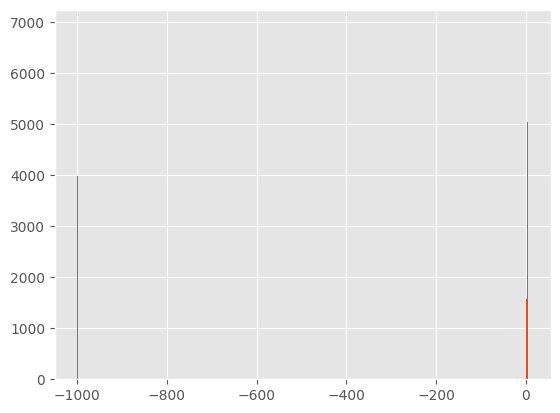

In [ ]:
# Гистограмма значений EF_b до чистки
plt.hist(df.EF_b, bins = np.arange(min(df.EF_b), max(df.EF_b) + 1, 1))

Между EF_b и FZ выбрали EF_b, так как там больше разных значений

In [ ]:
# Чистим целевую колонку

df = clear_main_col(df, 'EF_b')

(array([1563., 6893.,  845., 5049.]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

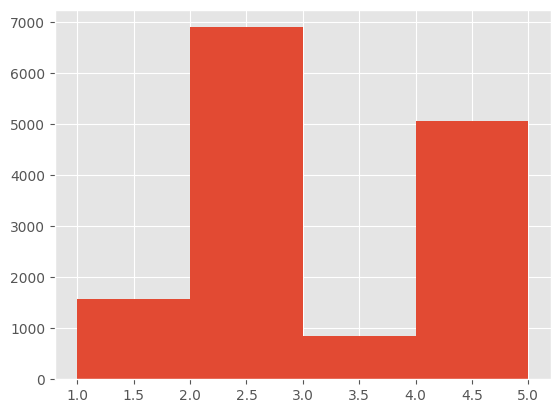

In [ ]:
# Проверяем результаты чистки

plt.hist(df.EF_b, bins = np.arange(min(df.EF_b), max(df.EF_b) + 1, 1))

## Чистим dataframe от лишних колонок и строк

In [ ]:
# Чистим DataFrame от колонок % пропусков в которых привышает 80% и от колонок, которые не влияют на результат

df = clear_df(
    dataframe = df, 
    present_persent = 80,
    drop_col = ['SATURAT_new', 'LIT_new', 'kp_new', 'FZ']
)

## Нормализация

In [ ]:
save_df = df.copy()

In [ ]:
df = save_df.copy()

In [ ]:
for col in df.columns:
    if col != "WELL" and col != "DEPTH":
        df[col] = preprocessing.MinMaxScaler().fit_transform(df[col].array.reshape(-1, 1))

DEPTH        DT    AGK        BK      GGKP        GK       GZ1  \
0      3826.5  0.373252  0.494  0.032872  0.405694  0.350927  0.130252   
1      3826.6  0.379043  0.452  0.031350  0.412811  0.365298  0.132653   
2      3826.7  0.387206  0.402  0.032516  0.427046  0.382418  0.127551   
3      3826.8  0.395360  0.346  0.033682  0.441281  0.401313  0.122449   
4      3826.9  0.405378  0.286  0.029796  0.432384  0.421804  0.119448   
...       ...       ...    ...       ...       ...       ...       ...   
18929  3583.6  0.866007  0.000  0.010493  0.165480  0.622993  0.057323   
18930  3583.7  0.819183  0.000  0.014509  0.268683  0.609776  0.062425   
18931  3583.8  0.795811  0.000  0.014509  0.284697  0.604542  0.069628   
18932  3583.9  0.773694  0.000  0.013570  0.316726  0.598953  0.074130   
18933  3584.0  0.760222  0.001  0.014444  0.330961  0.582720  0.079832   

            GZ2       GZ3       GZ4       NKT        PZ  EF_b WELL  
0      0.126593  0.218735  0.236787  0.010392  0.161637  0.75  190  
1      0.129626  0.216002  0.225968  0.009811  0.159994  0.75  190  
2      0.126188  0.211667  0.218997  0.009295  0.157006  0.75  190  
3      0.122750  0.207521  0.212027  0.009133  0.154019  0.75  190  
4      0.119515  0.201489  0.207033  0.009682  0.153122  0.75  190  
...         ...       ...       ...       ...       ...   ...  ...  
18929  0.047422  0.078221  0.102164  0.038212  0.009411  0.50  512  
18930  0.046916  0.076053  0.101852  0.043795  0.010457  0.50  512  
18931  0.045096  0.074168  0.102372  0.047733  0.013295  0.50  512  
18932  0.042265  0.072566  0.102476  0.052187  0.016582  0.50  512  
18933  0.039838  0.071058  0.101540  0.056705  0.020018  0.50  512  

[9180 rows x 14 columns]

## Разбиваем выборку

## Строем модель

### Метод опорных векторов



## Выводим графики

WELL №190


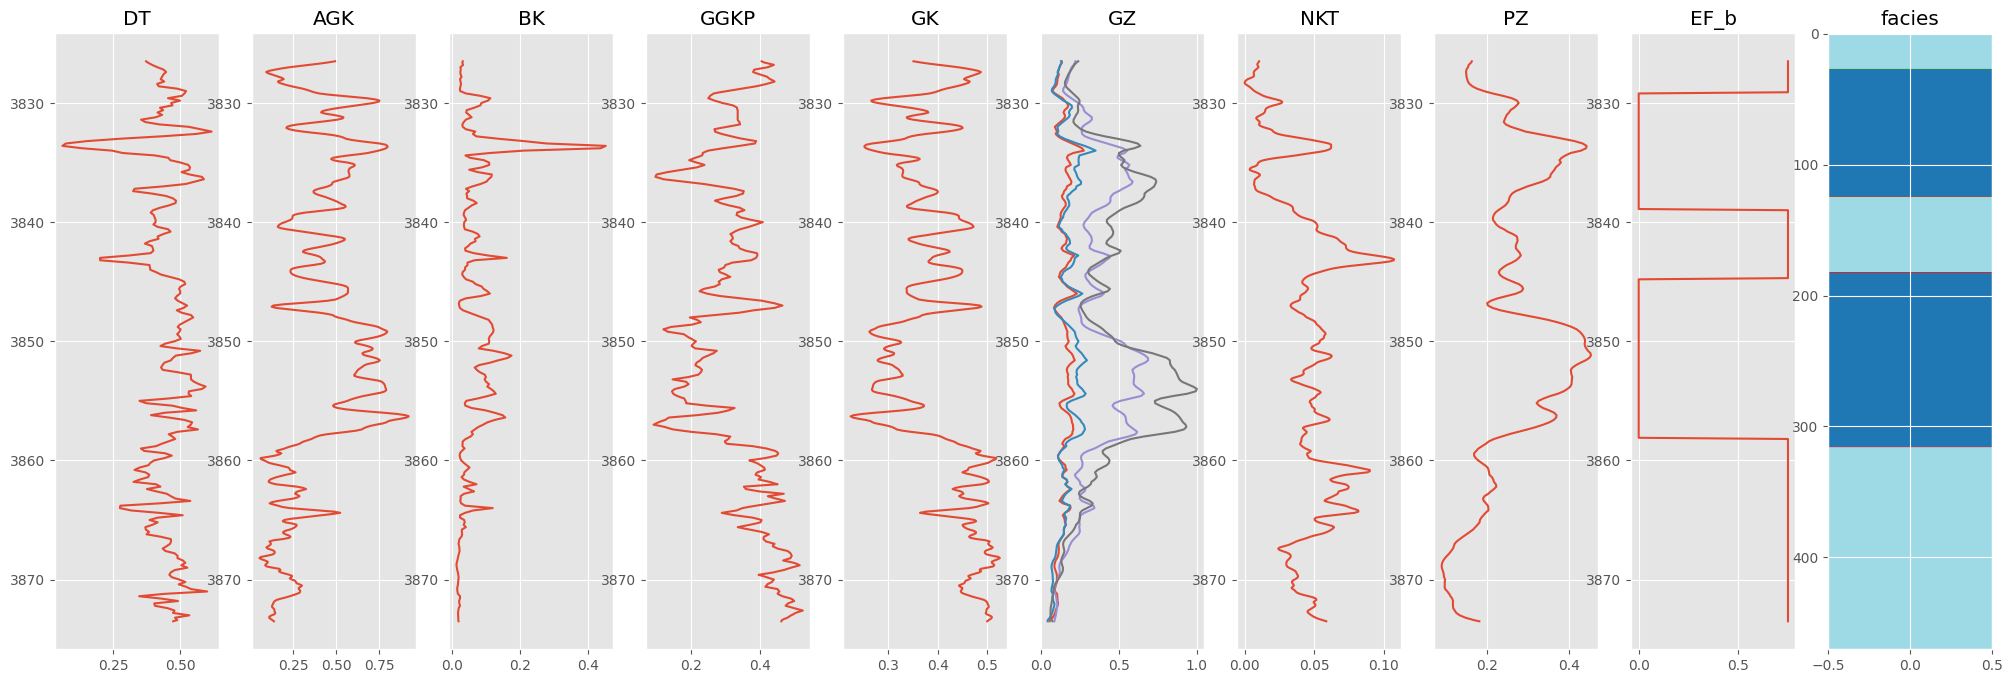

WELL №193


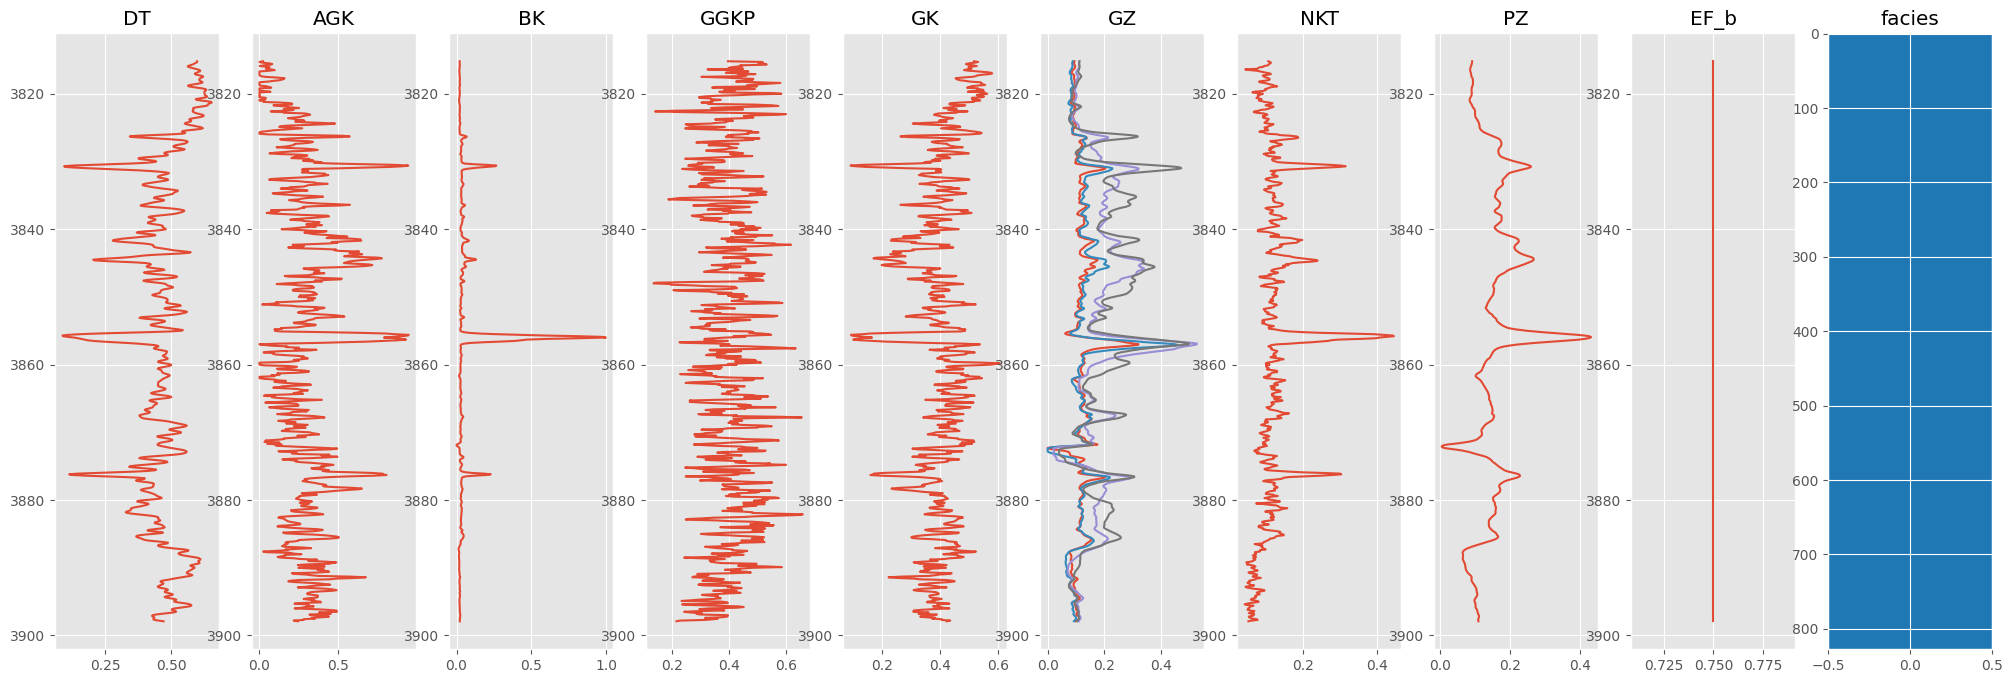

WELL №197


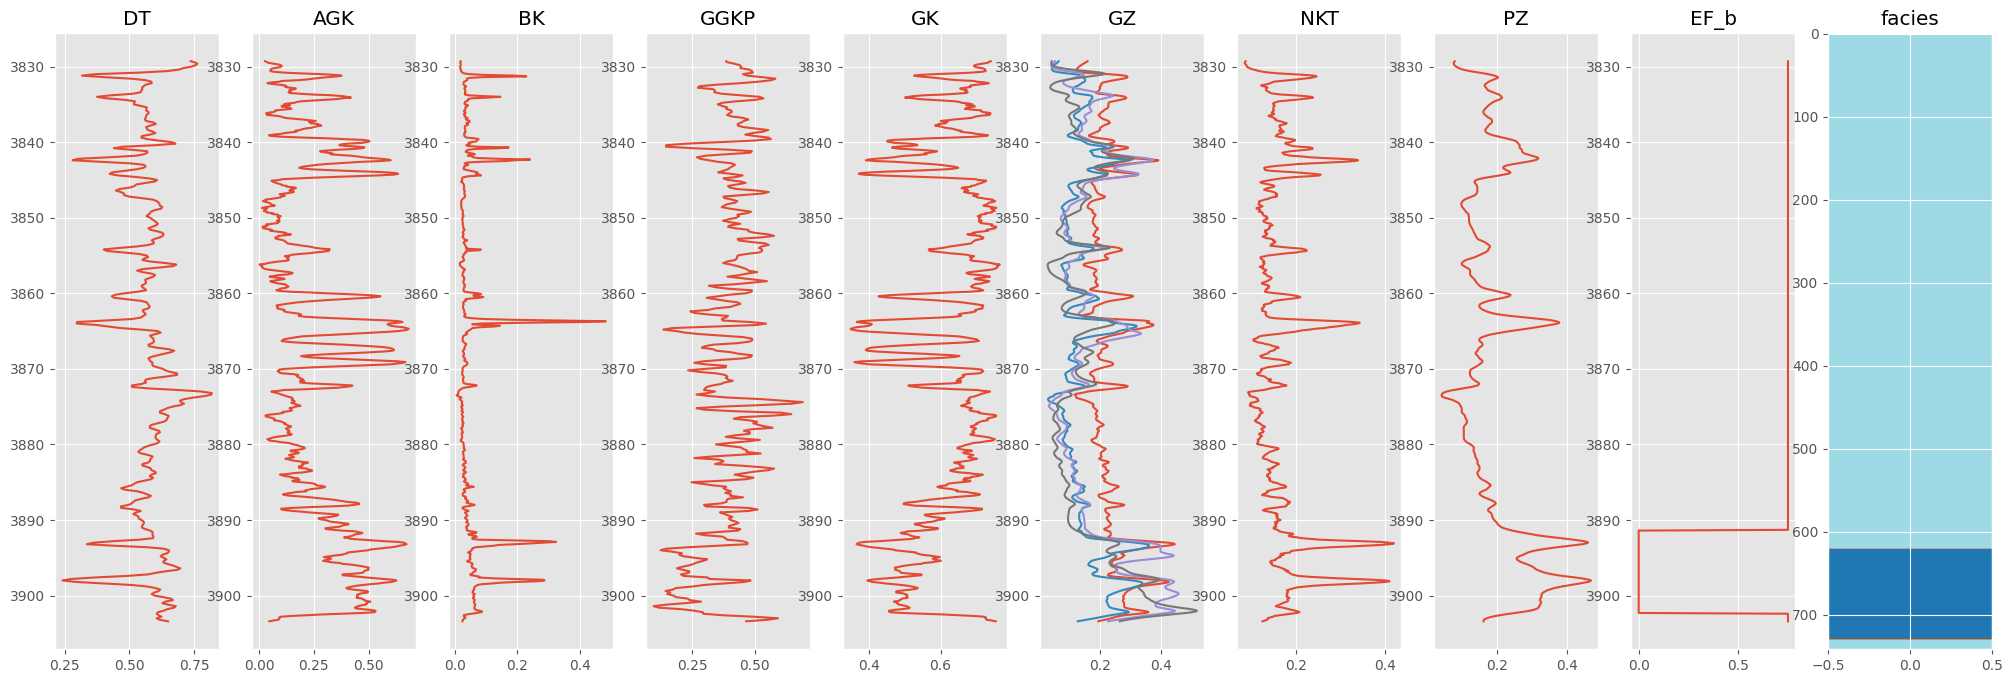

WELL №199


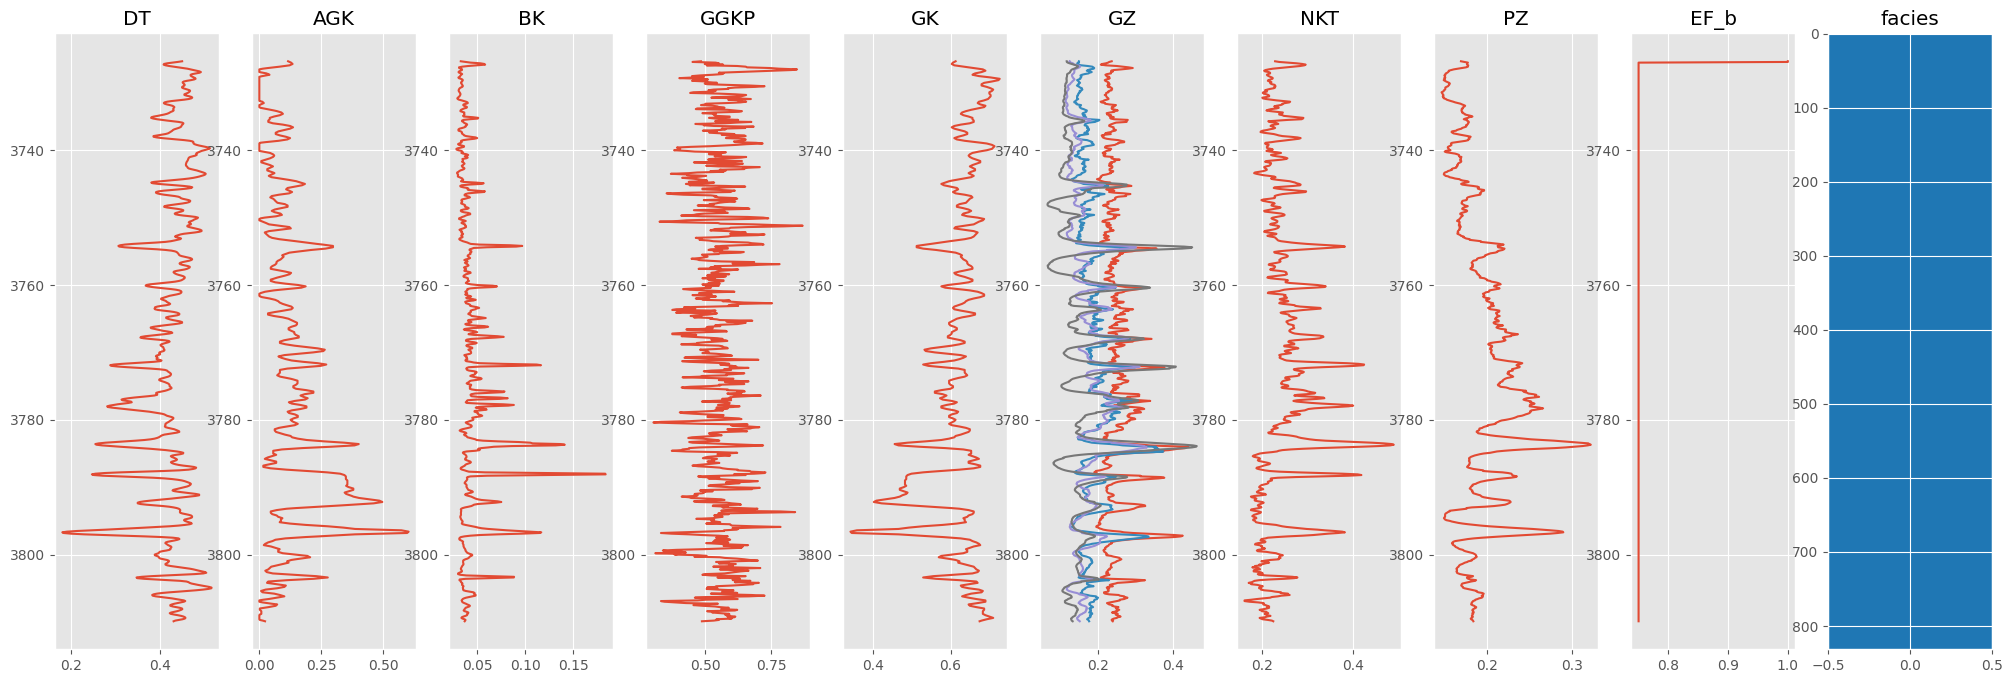

WELL №213


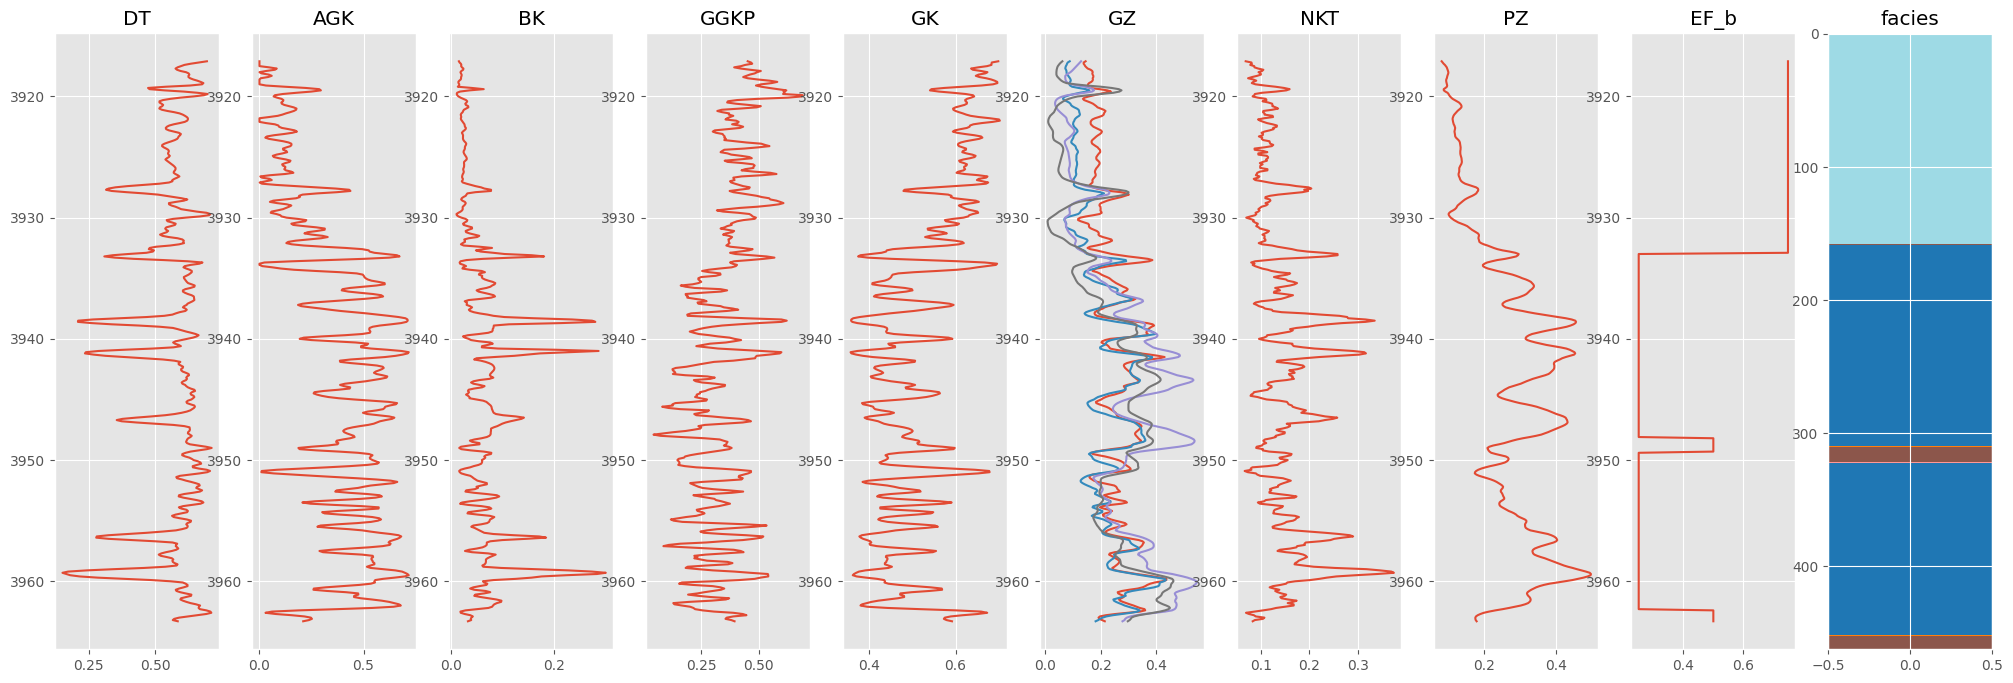

WELL №215


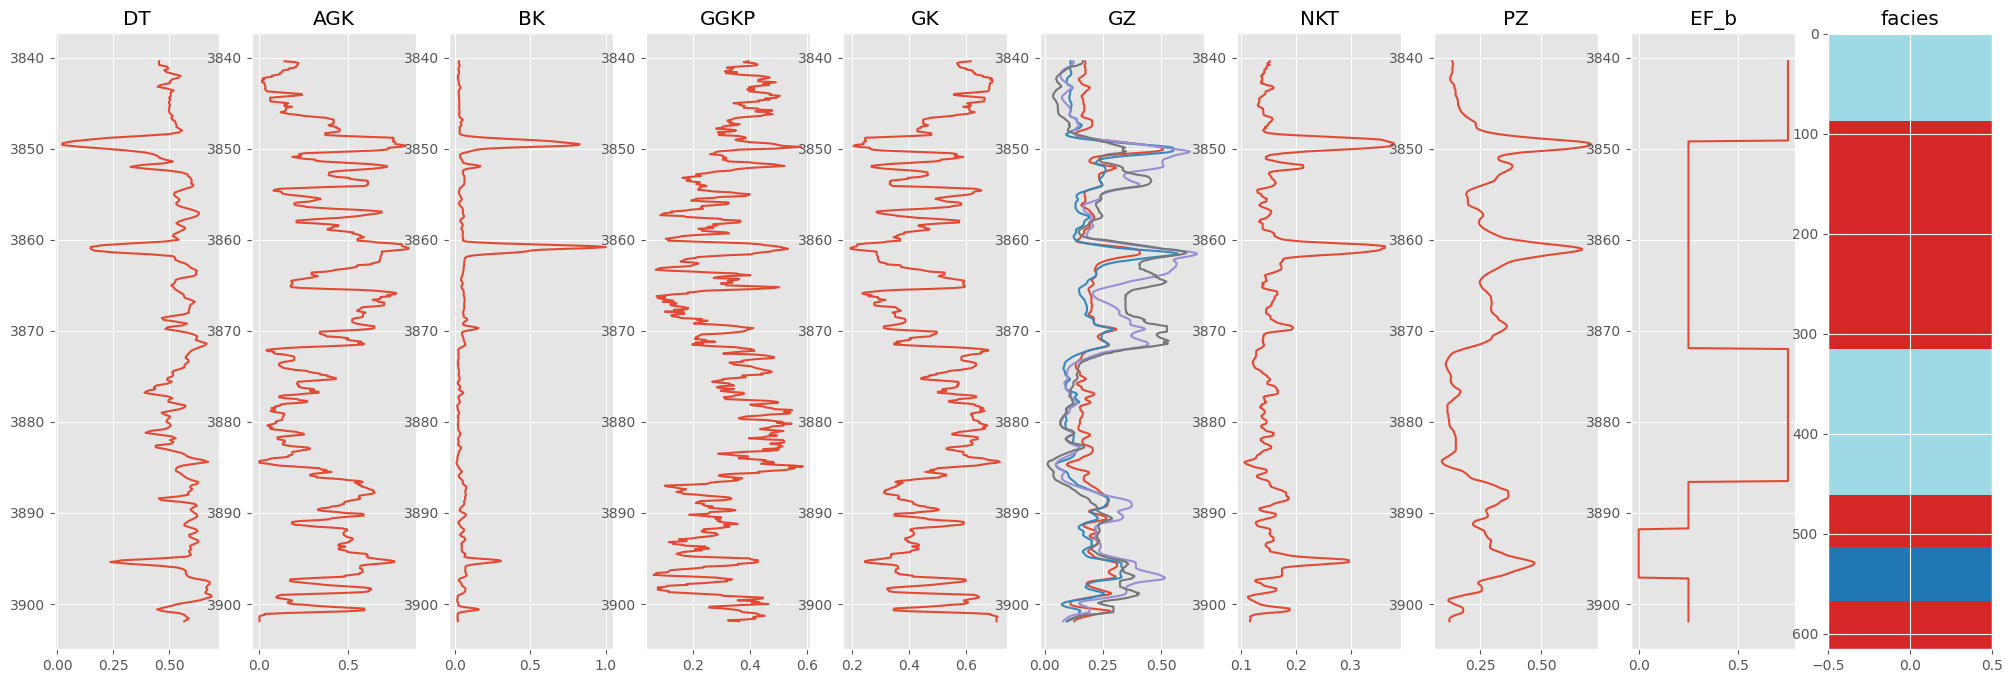

WELL №216


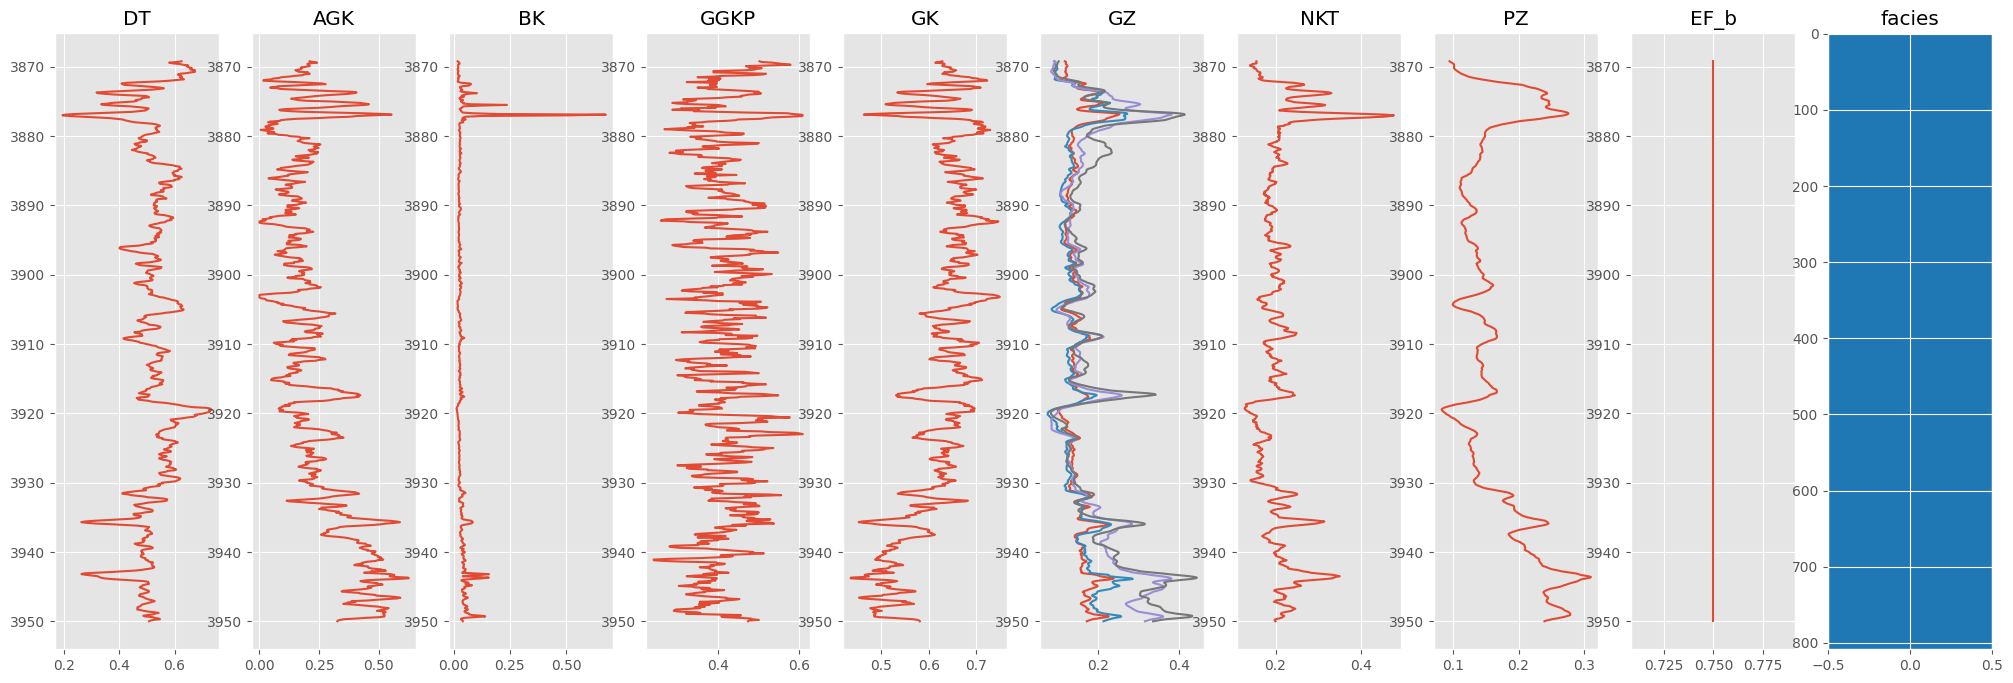

WELL №217


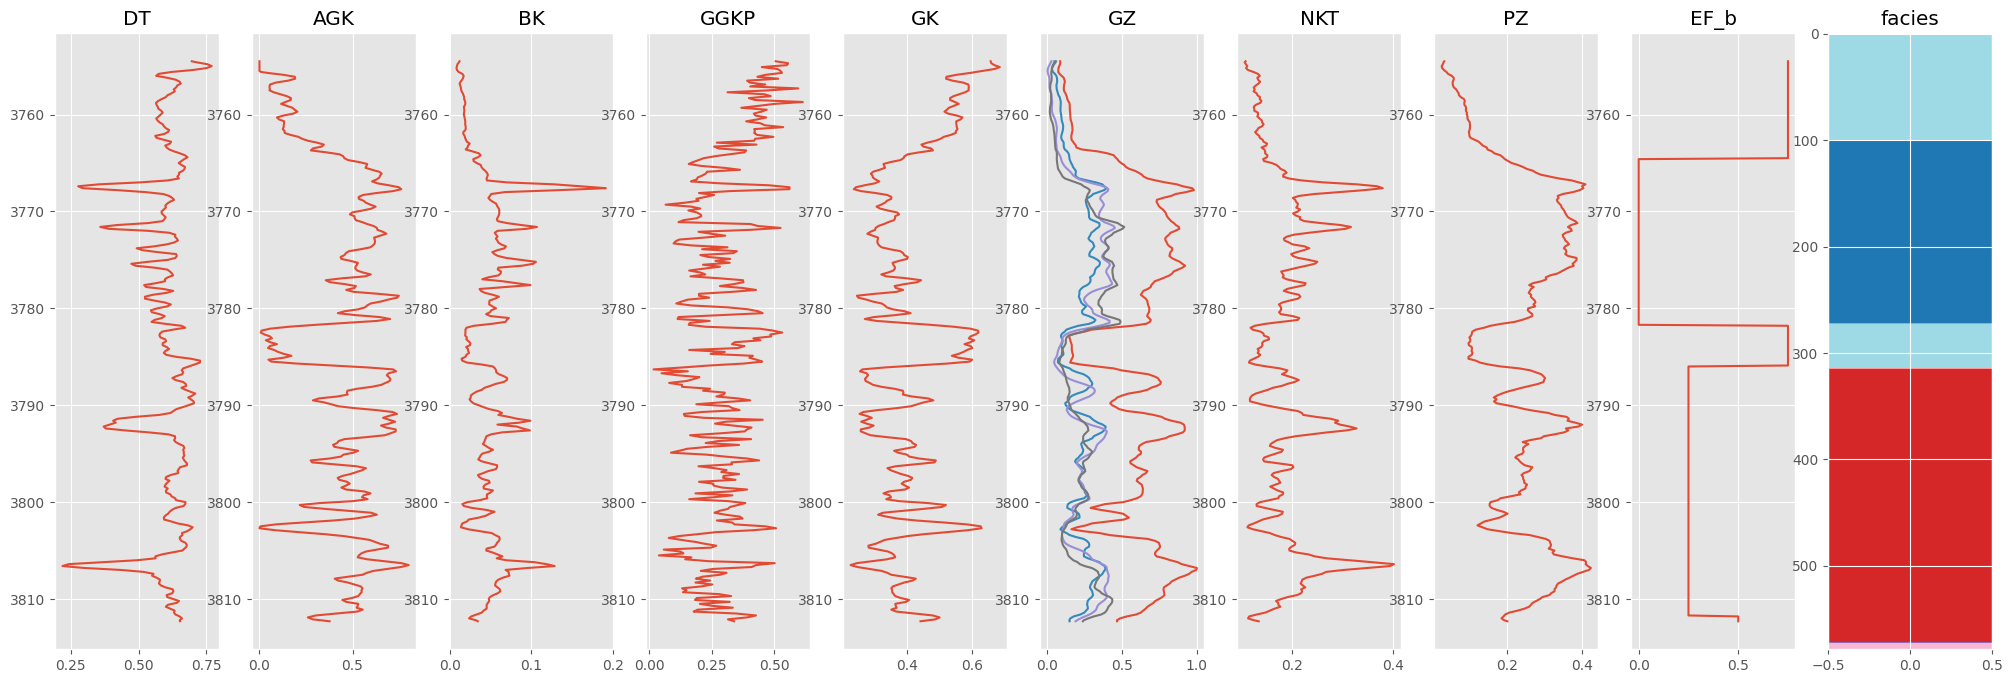

WELL №221


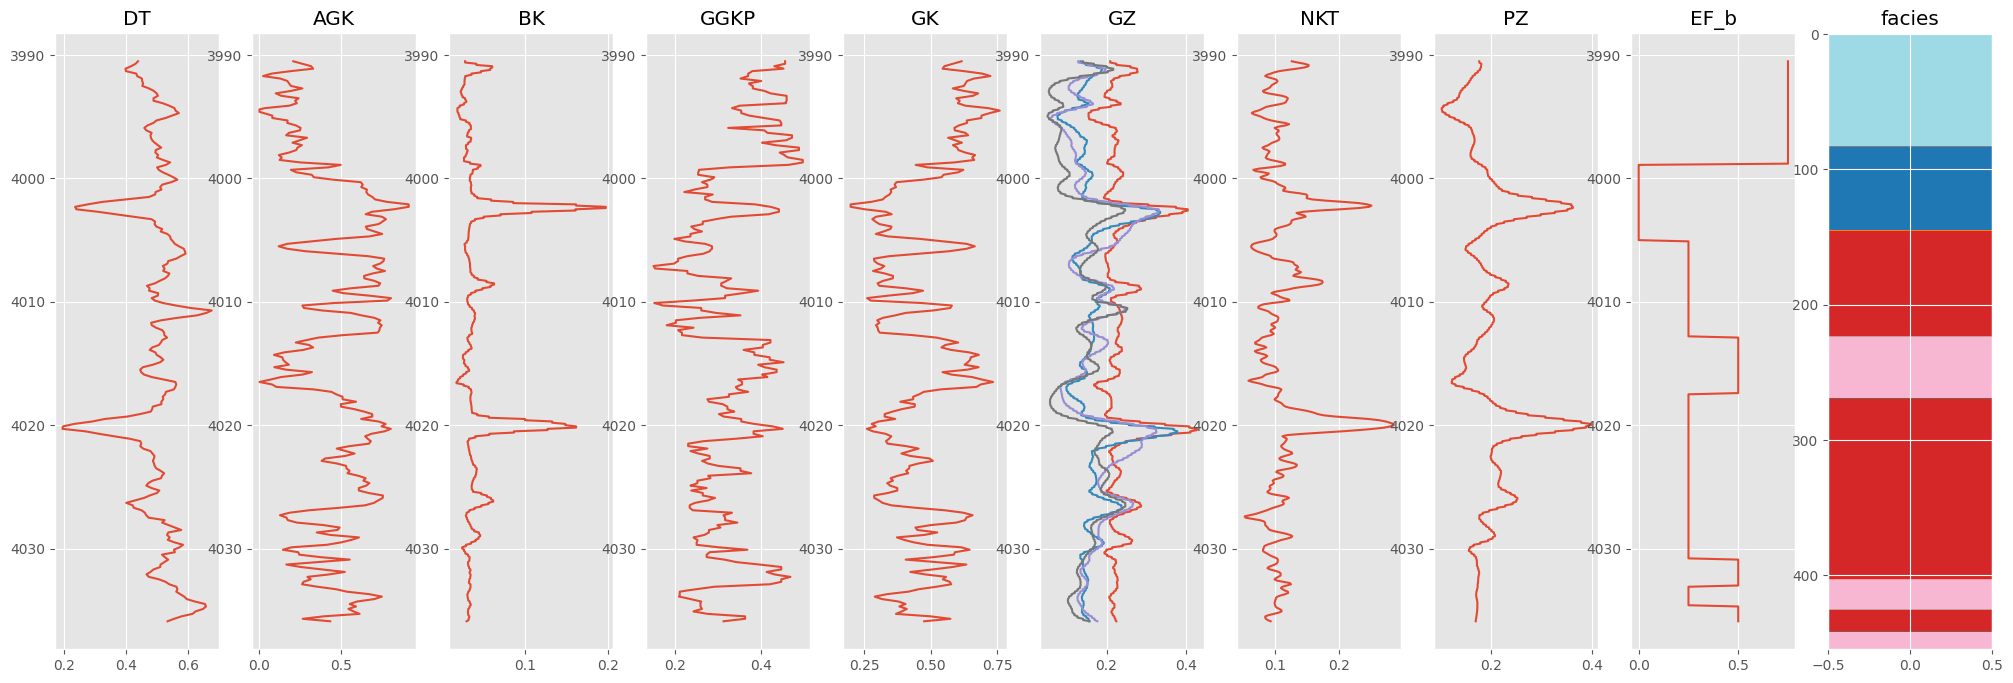

WELL №224


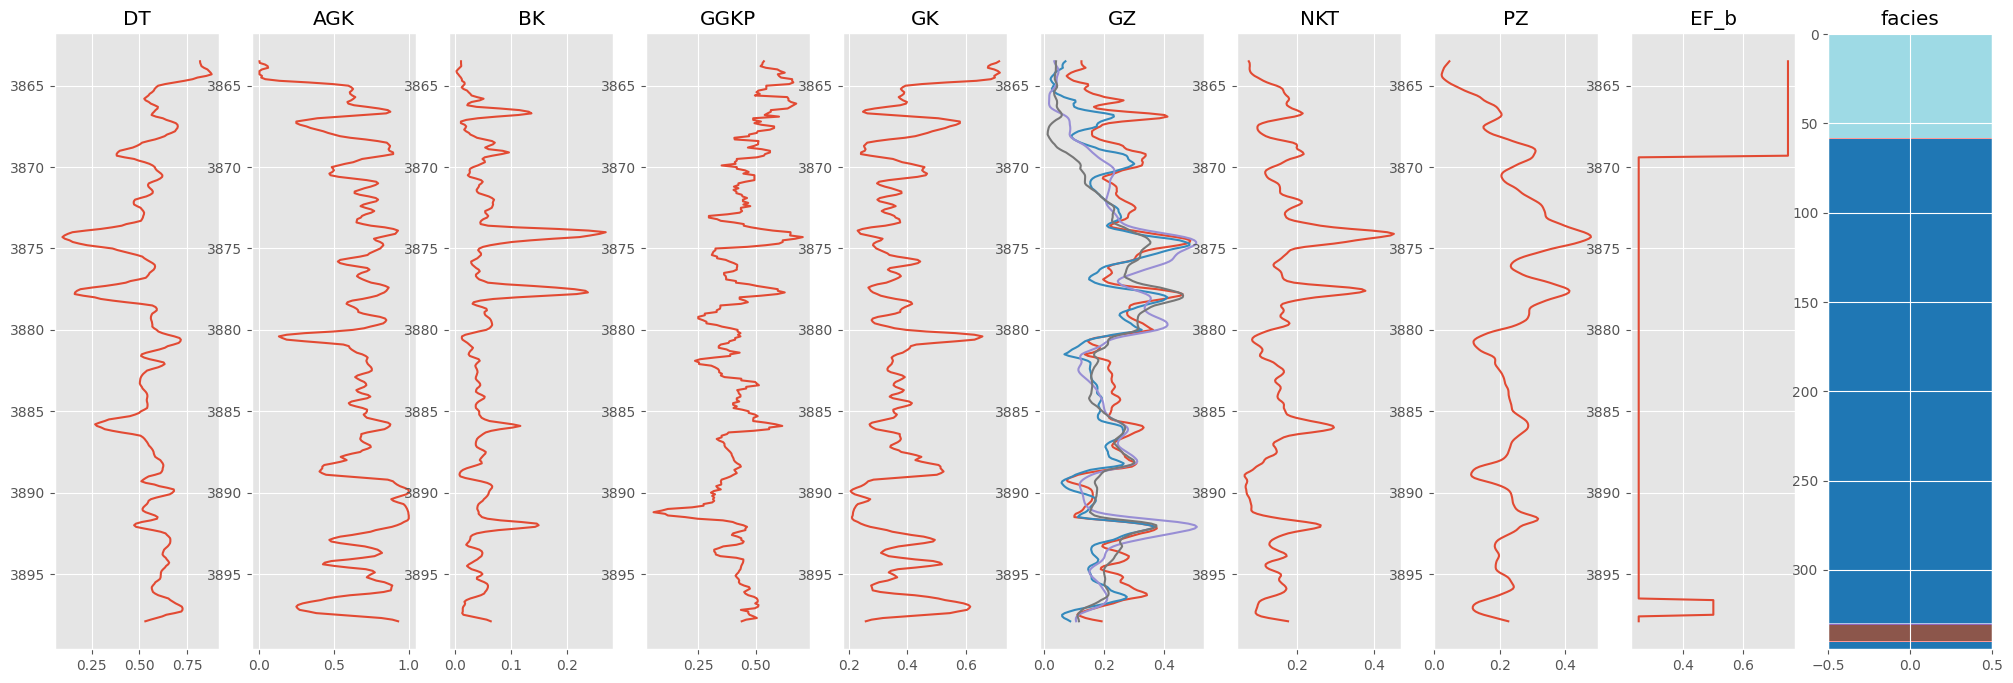

WELL №233


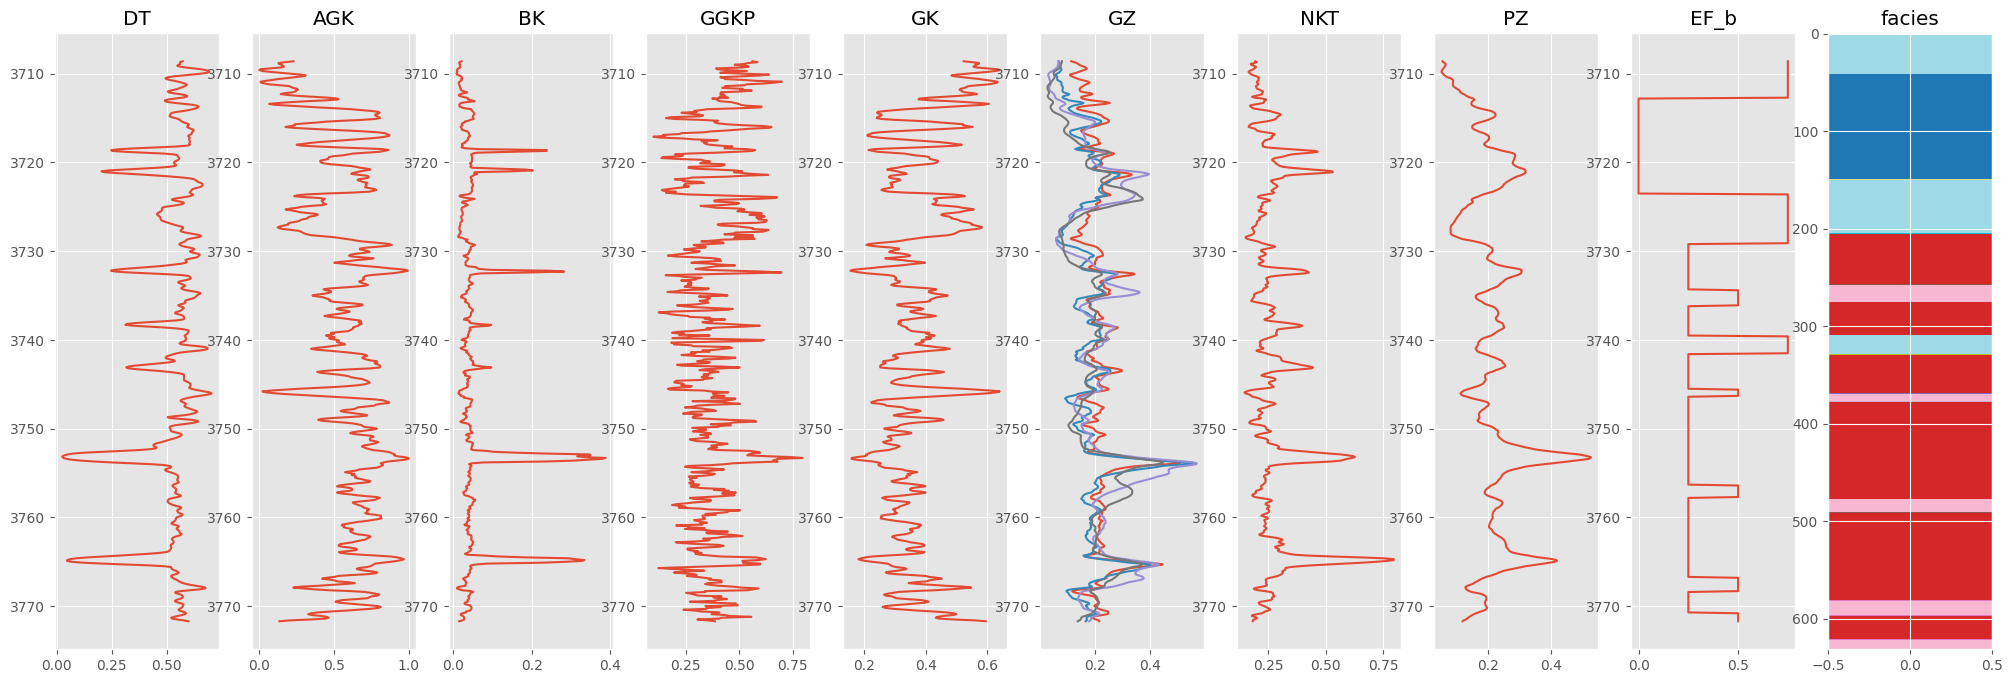

WELL №234


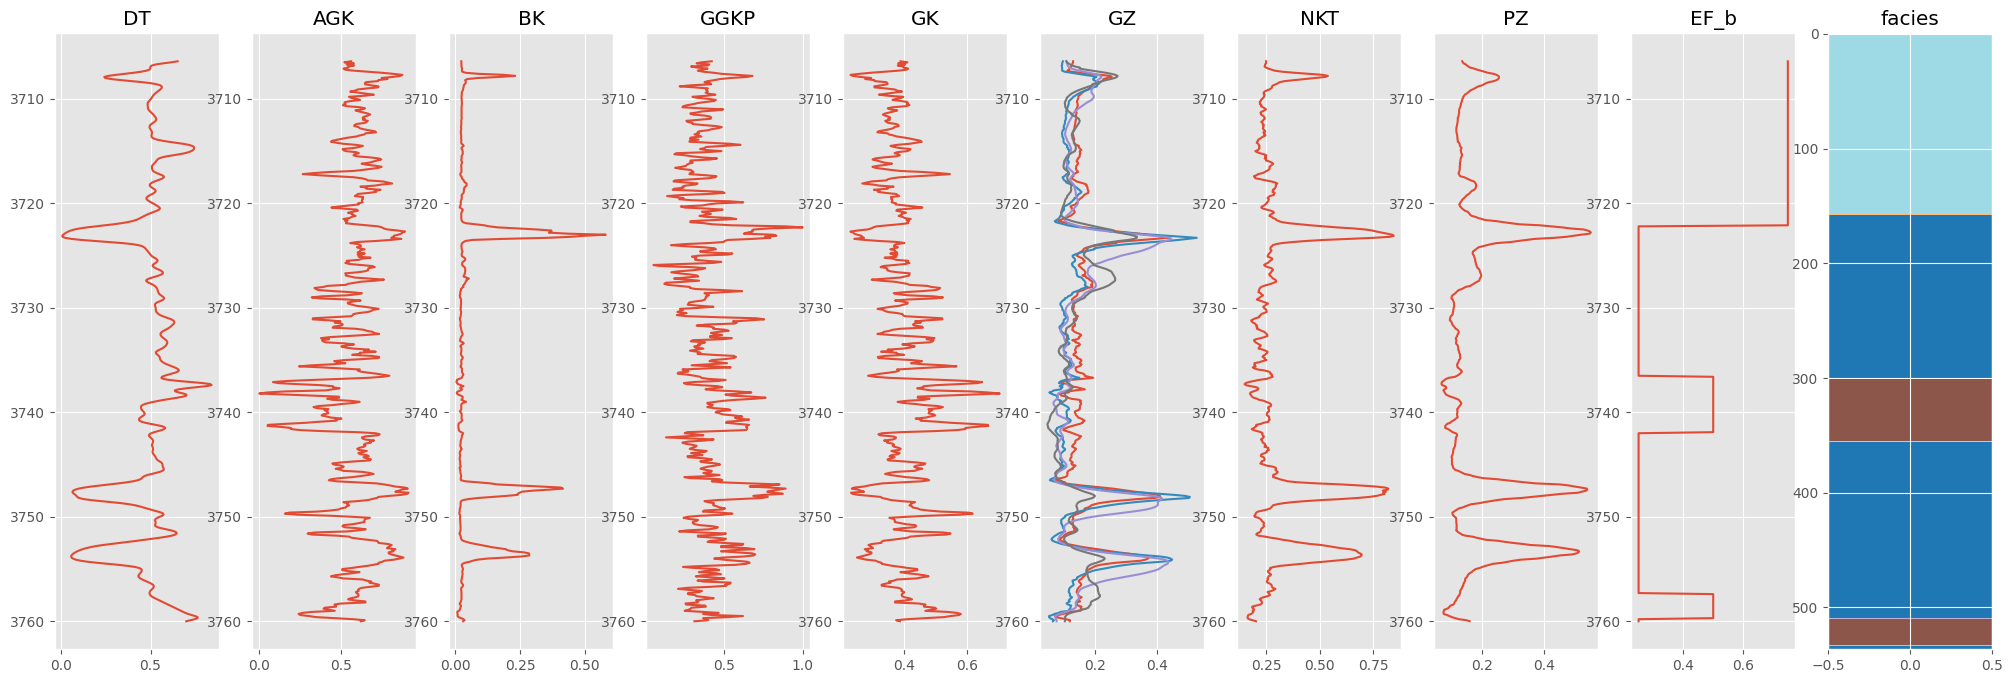

WELL №235


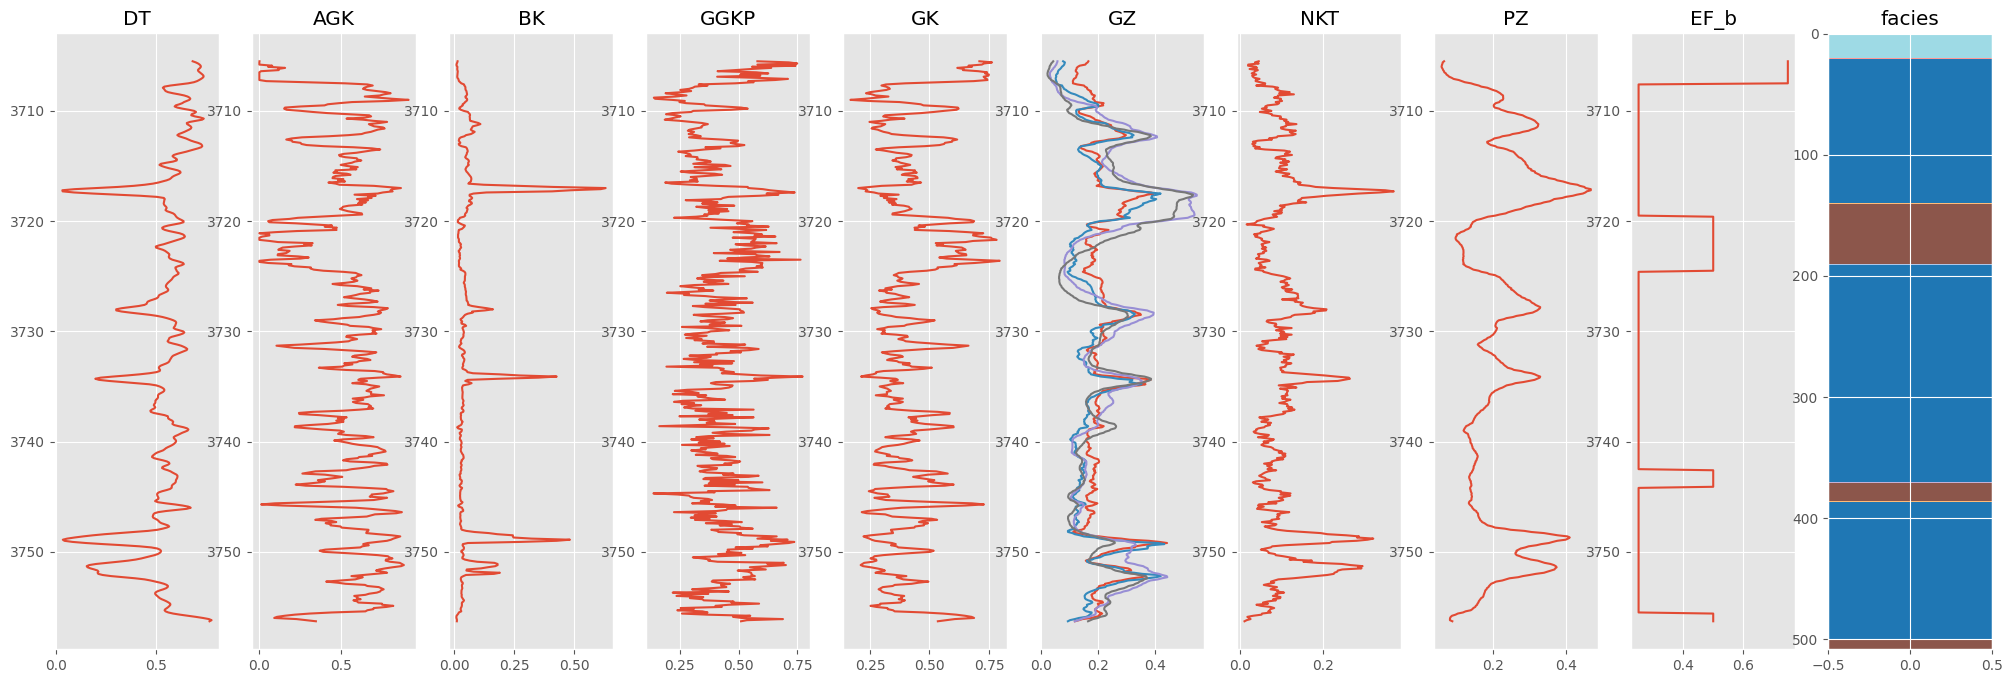

WELL №469


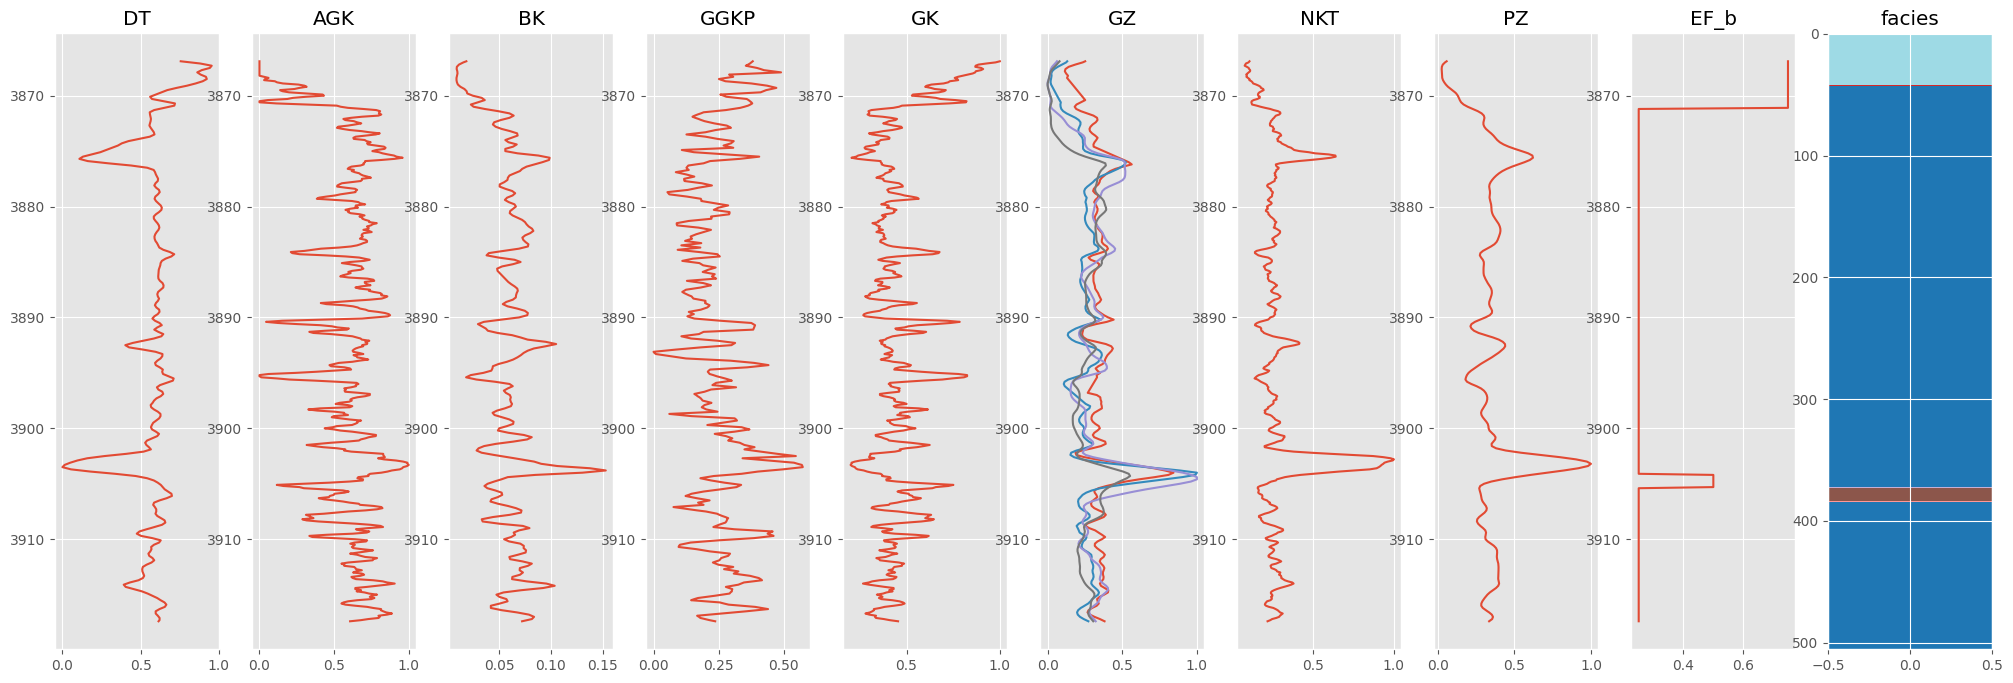

WELL №511


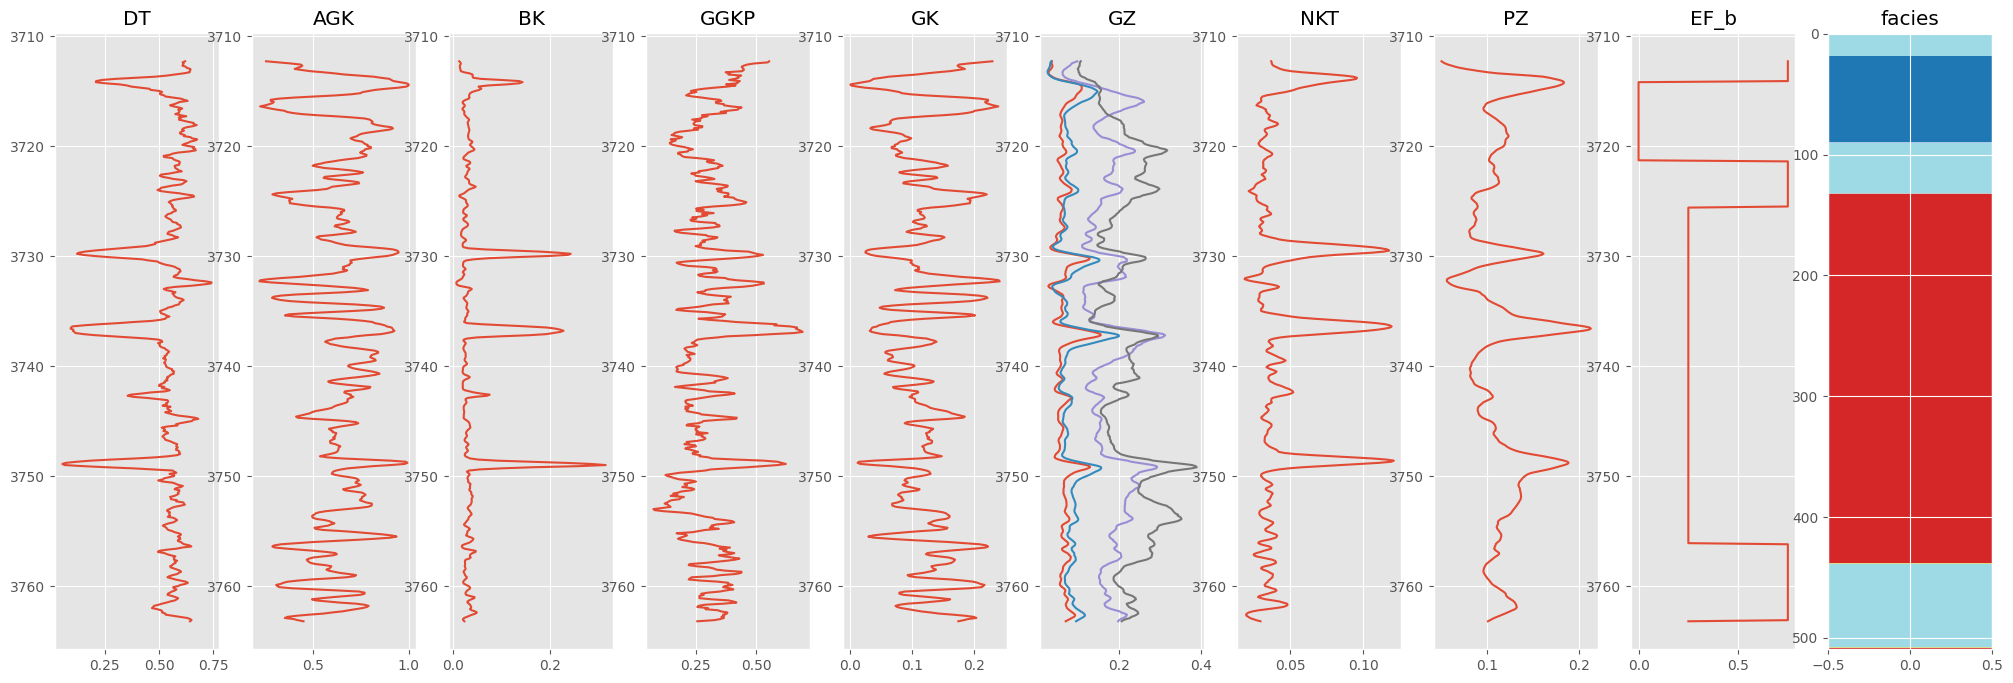

WELL №512


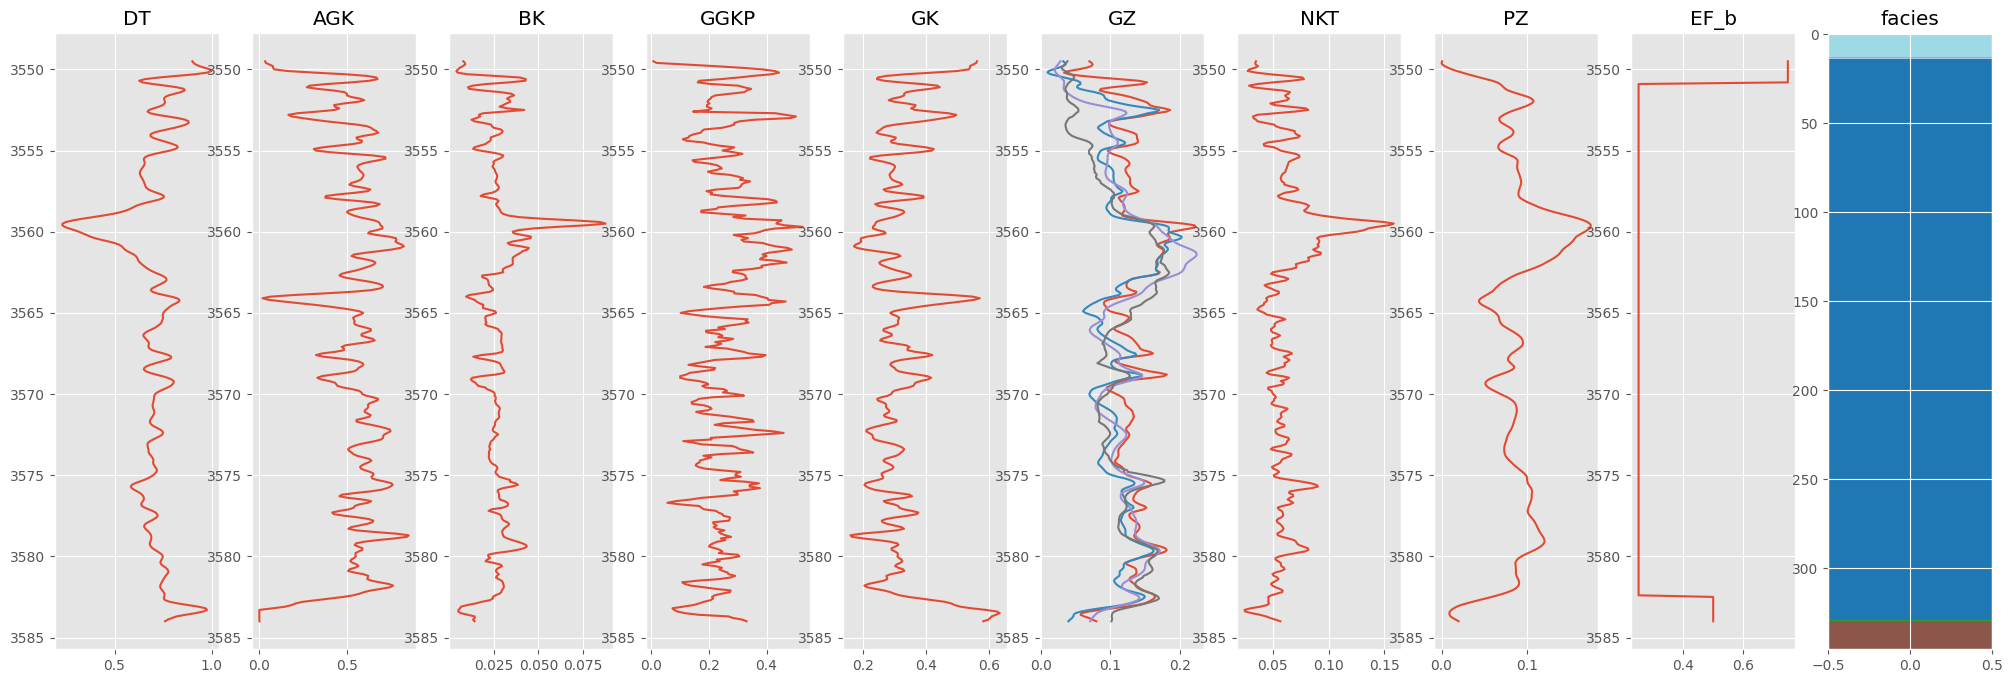

In [ ]:
# # Запускаем бесконечный цикл для вывода нужной нам скважины
# # while True:
# #     well_num = input('Введите номер скважины (0 - чтобы выйти из цикла):')

# # Выводим графики по всем скважинам
# for well_num in file_names:

#     if well_num == '0':
#         print('Конец\n')
#         break
#     # elif well_num not in file_names:
#     #     print('Такой скважины нет\n')
#     else:
#         if df[ df.WELL  == well_num].count().max() > 0:
#             well_name = well_num
#             measures_list = df.columns[1:-1]
            
#             plot_well_logs(well_name,measures_list,df,figsize=(25,8))
#         # else:
#         #     print('Данных по скважине нет\n')
        
